In [1]:
pwd

'/data2/mito_lineage/src/vireo'

In [2]:
INDIR="/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20"
COUNT_INDIR="/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex"
OUTDIR= "/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20/clones_dendro/"
#N_DONORS=4
DONOR=0
#INDIR=""
sample_names="Control,Flt3l" #"Control,Flt3l,Input"

In [3]:
from src.utils.data_io import setup_outdir
#setup_outdir(OUTDIR, dirs=('figures'))

fig_utils from mplh


In [4]:
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}


In [5]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import mplh.fig_utils as fu

import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


In [6]:
def filt_high(df, thresh):
    return df.loc[(df.mean(axis=1)<thresh)].index.values


# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

## Load cluster results and plot dendrograms

In [7]:
import seaborn as sns
from mplh import cluster_help as ch

In [8]:
out_f = join(OUTDIR, f"donor{DONOR}")

curr_ad_f = join(COUNT_INDIR, f"donor{DONOR}.AD.mtx")
curr_dp_f = join(COUNT_INDIR, f"donor{DONOR}.DP.mtx")



In [9]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t').sort_values(["donor", "donor_index", 
                                                                               "lineage", "lineage_index"])
cells_meta

,Unnamed: 0,level_0,index,ID,raw ID,new index,condition,donor,donor_index,lineage,lineage_index
0,0,2,2,AAACGAAAGTCGTGAG-1_Control,AAACGAAAGTCGTGAG-1,3,Control,0,1,NaN,NaN
1,1,4,4,AAACGAACACAATAAG-1_Control,AAACGAACACAATAAG-1,5,Control,0,2,NaN,NaN
2,2,9,9,AAACGAAGTAAGTCTC-1_Control,AAACGAAGTAAGTCTC-1,10,Control,0,3,NaN,NaN
3,3,12,12,AAACGAAGTGGATTCT-1_Control,AAACGAAGTGGATTCT-1,13,Control,0,4,NaN,NaN
4,4,14,14,AAACGAATCGCAACTA-1_Control,AAACGAATCGCAACTA-1,15,Control,0,5,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
14877,3746,17371,17371,TTTGGTTGTTAACCAC-1_Flt3l,TTTGGTTGTTAACCAC-1,17372,Flt3l,3,3747,18.0,174.0
14878,3747,17378,17378,TTTGTGTAGAGAGTAG-1_Flt3l,TTTGTGTAGAGAGTAG-1,17379,Flt3l,3,3748,NaN,NaN
14879,3748,17394,17394,TTTGTGTGTATTCTGG-1_Flt3l,TTTGTGTGTATTCTGG-1,17395,Flt3l,3,3749,NaN,NaN
14880,3749,17404,17404,TTTGTGTTCGTTACAG-1_Flt3l,TTTGTGTTCGTTACAG-1,17405,Flt3l,3,3750,NaN,NaN


In [10]:
def calc_mean(cells, af):
    #print(cells.head())
    return af.iloc[:, cells['donor_index'].values-1].mean(axis=1)
    

In [11]:
TO_SAVE_FIG=False

In [12]:
#for n in range(N_DONORS):
print(curr_ad_f)
print(curr_dp_f)
curr_ad = mmread(curr_ad_f).tocsc()
curr_dp = mmread(curr_dp_f).tocsc()
AD_df = pd.DataFrame(curr_ad.todense())
AD_df.index.name = "Variant"
AD_df.columns.name = "Cell"
DP_df = pd.DataFrame(curr_dp.todense())
DP_df.index.name = "Variant"
DP_df.columns.name = "Cell"
AF_df = AD_df/(DP_df+0.001)
#AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]
colors={val[0]:val[1] for val in zip(sample_names, sns.color_palette('Set2', len(sample_names)))}
curr_labels["Color"] = curr_labels["condition"].map(colors)

/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/donor0.AD.mtx
/data2/mito_lineage/output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/donor0.DP.mtx


/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


clustering
cmap None


/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No handles with labels found to put in legend.


clustering
cmap None
clustering
cmap None


/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No handles with labels found to put in legend.


clustering
cmap None
clustering
cmap None


/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No handles with labels found to put in legend.


clustering
cmap None
clustering
cmap None


/home/isshamie/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
No handles with labels found to put in legend.


clustering
cmap None


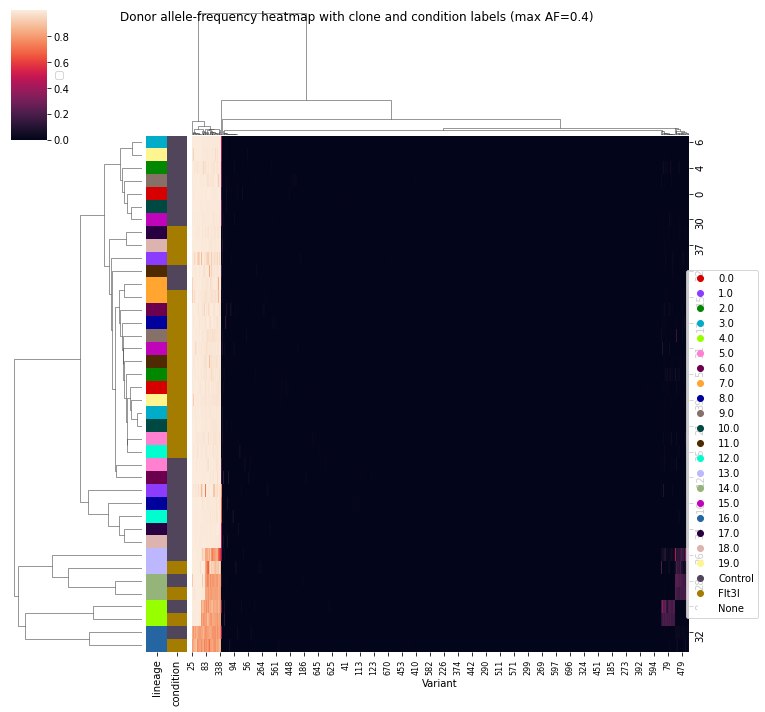

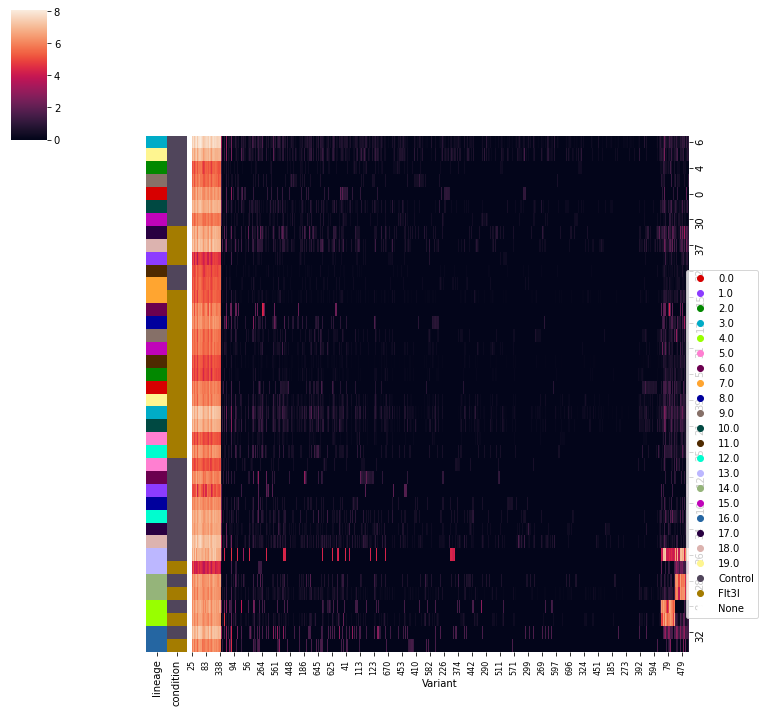

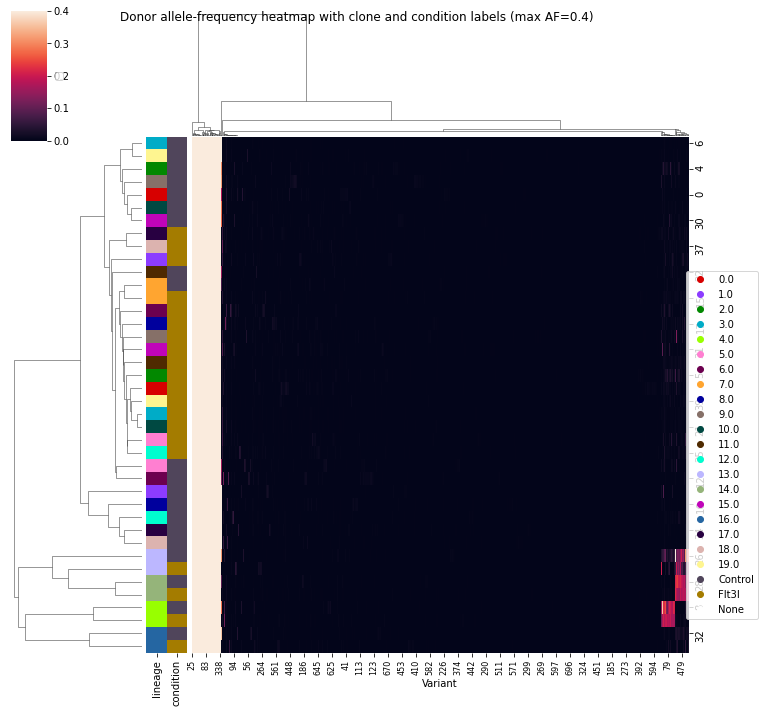

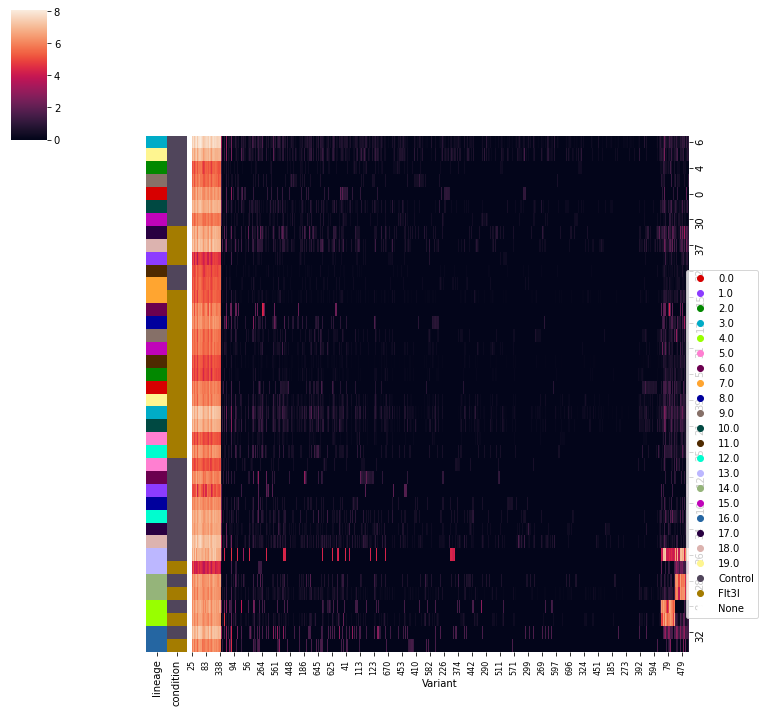

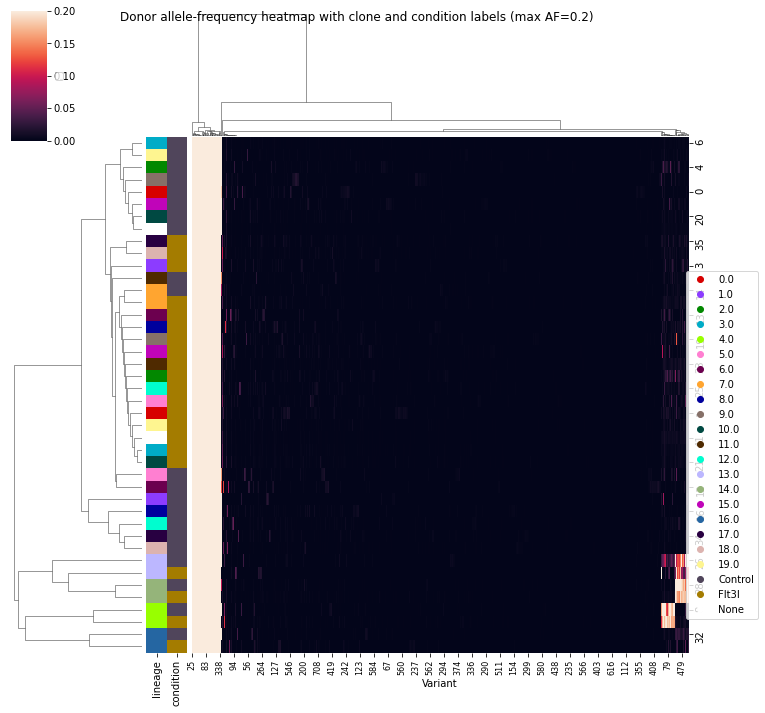

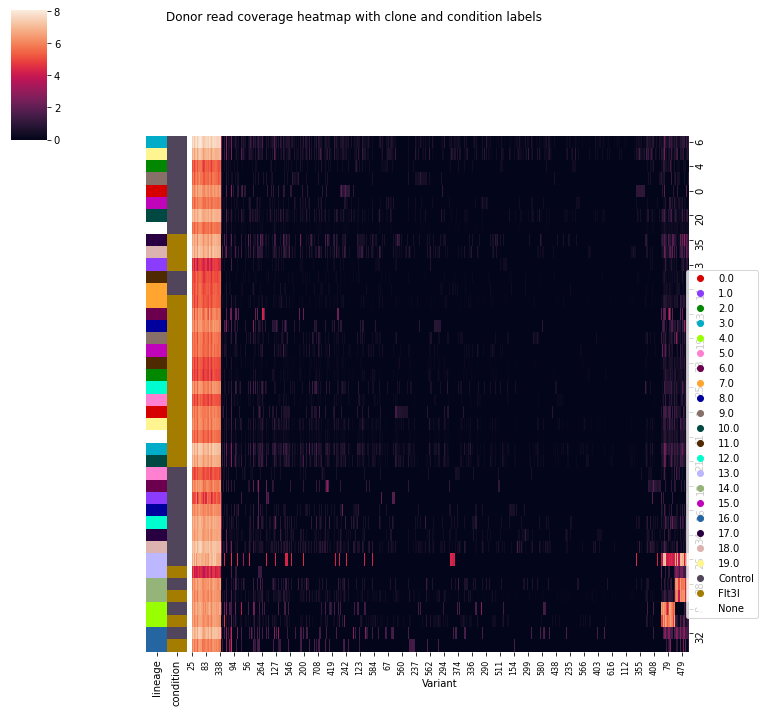

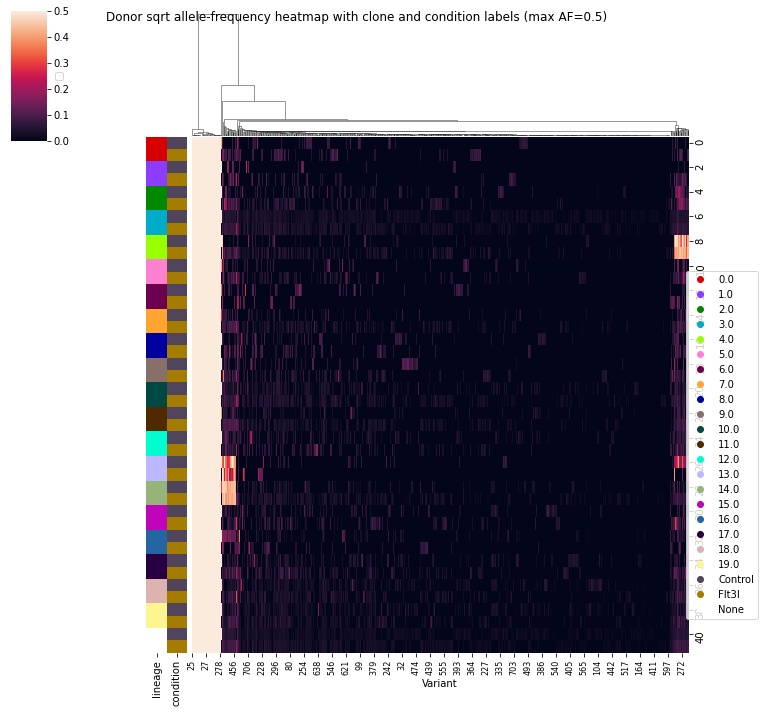

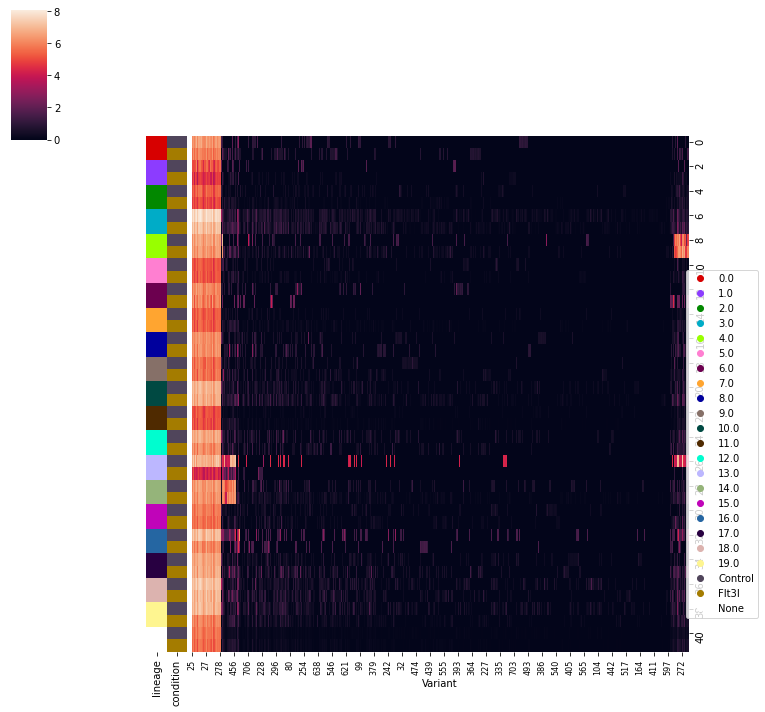

In [13]:


mean_af = curr_labels.groupby(["lineage", "condition"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage", "condition"]]

#mean_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_mean, af=nlog2(DP_df))
mean_dp = curr_labels.groupby(["lineage", "condition"]).apply(calc_mean, af=np.log2(DP_df+1))
anno_dp = mean_dp.reset_index()[["lineage", "condition"]]
mean_dp = mean_dp.reset_index(drop=True)

na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

na_mean_af
na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None", "None"], "condition":na_mean_af.index})), ignore_index=True)
na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)

na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)


################
## Plotting
################
## 1.
g1 = ch.plot_cluster((mean_af.reset_index(drop=True)), row_meta=anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True)
g1.figure.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.4)")
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
fu.helper_save(out_f+".raw.clust.AF.png", f=g1.figure)

inds = g1.dendrogram_row.dendrogram["leaves"]
cols = g1.dendrogram_col.dendrogram["leaves"]
g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=anno_dp.iloc[inds])
fu.helper_save(out_f+".raw.clust.DP.png", f=g1d.figure)


# ## 2.
g2 = ch.plot_cluster((mean_af.reset_index(drop=True)), row_meta=anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True, vmax=0.4, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
g2.figure.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.4)")
fu.helper_save(out_f+".raw.clust.max4.AF.png")
inds = g2.dendrogram_row.dendrogram["leaves"]
cols = g2.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(mean_dp.iloc[inds,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=anno_dp.iloc[inds])
fu.helper_save(out_f+".raw.clust.max4.DP.png")


## 3.
g = ch.plot_cluster(na_concat, row_meta=na_anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=True, to_col_clust=True, vmax=0.2, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.2)")
fu.helper_save(out_f+".na.clust.max2.AF.png")

inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(na_dp_concat.iloc[inds,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=na_anno.iloc[inds])
plt.suptitle("Donor read coverage heatmap with clone and condition labels ")
fu.helper_save(out_f+".na.clust.max2.DP.png")


# ## 4.
g = ch.plot_cluster(np.sqrt(na_concat), row_meta=na_anno, #curr_labels[["condition", "lineage"]], 
                    to_row_clust=False, to_col_clust=True, vmax=0.5, vmin=0)
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
fu.helper_save(out_f+".na.max5.AF.png")
#inds = g.dendrogram_row.dendrogram["leaves"]
cols = g.dendrogram_col.dendrogram["leaves"]
ch.plot_cluster(na_dp_concat.iloc[:,cols], to_row_clust=False, to_col_clust=False, 
                        row_meta=na_anno.iloc[inds])
fu.helper_save(out_f+".na.max5.DP.png")

#plt.close('all')

## Get variants and types of variants